<a href="https://colab.research.google.com/github/shivasrinivasaraopinnamaneni/info5731-fall2021/blob/main/In_class_exercise_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The seventh in-class-exercise (40 points in total, 10/20/2021)**

Question description: Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks:

## (1) (15 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [35]:
#Downloading stopwords
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [36]:
pip install spacy

In [37]:
pip install pyLDAvis==2.1.2

     |████████████████████████████████| 1.6 MB 5.1 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97738 sha256=c4ddb7831ee7f63395384dfc86c49ad8cf0834176ac2f896facec7ec0a9b8456
  Stored in directory: /root/.cache/pip/wheels/3b/fb/41/e32e5312da9f440d34c4eff0d2207b46dc9332a7b931ef1e89
Successfully built pyLDAvis


In [38]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [39]:
#Preparing NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [42]:
# Importing Dataset
df = pd.read_csv('/content/text_emotion.csv')

df.head()

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


In [44]:
# Converting to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['i know i was listenin to bad habit earlier and i started freakin at his part '
 '=[']


In [45]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['know', 'was', 'listenin', 'to', 'bad', 'habit', 'earlier', 'and', 'started', 'freakin', 'at', 'his', 'part']]


In [46]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['know', 'was', 'listenin', 'to', 'bad', 'habit', 'earlier', 'and', 'started', 'freakin', 'at', 'his', 'part']


In [47]:
# Defining functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [48]:
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['know', 'bad', 'habit', 'earlier', 'start', 'freakin', 'part']]


In [49]:
# Creating Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]]


In [50]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('bad', 1),
  ('earlier', 1),
  ('freakin', 1),
  ('habit', 1),
  ('know', 1),
  ('part', 1),
  ('start', 1)]]

In [51]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [52]:

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.349*"day" + 0.071*"last" + 0.062*"work" + 0.052*"much" + 0.040*"nice" + '
  '0.040*"take" + 0.026*"guy" + 0.021*"ever" + 0.017*"early" + '
  '0.014*"picture"'),
 (1,
  '0.169*"good" + 0.112*"thank" + 0.025*"try" + 0.022*"sound" + 0.022*"live" + '
  '0.020*"pretty" + 0.020*"call" + 0.019*"check" + 0.018*"family" + '
  '0.016*"hear"'),
 (2,
  '0.216*"love" + 0.105*"watch" + 0.073*"still" + 0.040*"may" + 0.032*"leave" '
  '+ 0.030*"yesterday" + 0.029*"give" + 0.029*"eat" + 0.024*"beautiful" + '
  '0.021*"clean"'),
 (3,
  '0.252*"be" + 0.221*"go" + 0.087*"night" + 0.066*"quot" + 0.039*"have" + '
  '0.032*"bed" + 0.021*"talk" + 0.013*"welcome" + 0.012*"must" + 0.012*"send"'),
 (4,
  '0.131*"today" + 0.120*"know" + 0.070*"sleep" + 0.054*"enjoy" + 0.045*"play" '
  '+ 0.039*"weekend" + 0.037*"keep" + 0.036*"let" + 0.030*"will" + '
  '0.020*"tea"'),
 (5,
  '0.109*"home" + 0.056*"finally" + 0.055*"hour" + 0.051*"movie" + '
  '0.034*"finish" + 0.031*"happen" + 0.031*"change" + 0.027*"he

In [53]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.120308747318273

Coherence Score:  0.41722399661891724


In [55]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
1      0.354359 -0.253768       1        1  9.306229
3      0.128581  0.192454       2        1  8.617505
0      0.147420  0.279229       3        1  6.836764
14     0.091046  0.089570       4        1  6.051790
2     -0.010810 -0.001507       5        1  5.387374
16    -0.026456 -0.006940       6        1  5.259657
4     -0.028176 -0.015745       7        1  4.976306
9     -0.032325 -0.013704       8        1  4.911051
10    -0.045101 -0.020578       9        1  4.630822
19    -0.026089 -0.013074      10        1  4.581421
15    -0.035864 -0.015393      11        1  4.507089
18    -0.028560 -0.017650      12        1  4.377683
6     -0.055456 -0.022179      13        1  4.230528
8     -0.058520 -0.026399      14        1  4.093585
7     -0.058736 -0.022714      15        1  4.066960
5     -0.057369 -0.024234      16        1  3.855209
12    -0.062190 -0.026867      17        1  3.814431
11    -0.063747 -0.026953      18        1  3.769214
17    -0.057895 -0.025192      19        1  3.607449
13    -0.074111 -0.028357      20        1  3.118933, topic_info=       Term         Freq        Total Category  logprob  loglift
139     day  4854.000000  4854.000000  Default  30.0000  30.0000
16       be  4426.000000  4426.000000  Default  29.0000  29.0000
13       go  3876.000000  3876.000000  Default  28.0000  28.0000
396    good  3209.000000  3209.000000  Default  27.0000  27.0000
31      get  2382.000000  2382.000000  Default  26.0000  26.0000
...     ...          ...          ...      ...      ...      ...
2107   pray    46.900207    47.816126  Topic20  -4.9075   3.4483
1716  quote    44.792096    45.708015  Topic20  -4.9535   3.4474
1625  stand    43.372197    44.288116  Topic20  -4.9857   3.4468
1143  bitch    42.121088    43.037007  Topic20  -5.0150   3.4462
312    code    41.850385    42.766304  Topic20  -5.0214   3.4460

[633 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
188        7  0.993152        able
1348      20  0.987899  absolutely
1704       8  0.984556      accept
194       12  0.990191     account
3379      19  0.983627         act
...      ...       ...         ...
157       17  0.997452        year
10923      2  0.953724        yess
941        5  0.997142   yesterday
463        1  0.997303         yet
2957      20  0.984921       yummy

[603 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 15, 3, 17, 5, 10, 11, 20, 16, 19, 7, 9, 8, 6, 13, 12, 18, 14])

In [56]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

--2021-10-23 17:25:20--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  12.9MB/s    in 1.2s    

2021-10-23 17:25:21 (12.9 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]



In [57]:
!unzip mallet-2.0.8.zip

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classify  
  inflating: mallet-2.0.8/bin/text2vectors  
  inflating: mallet-2.0.8/bin/vectors2classify  
  inflating: mallet-2.0.8/bin/vectors2info  
  inflating: mallet-2.0.8/bin/vectors2topics  
  inflating: mallet-2.0.8/bin/vectors2vectors  
  inflating: mallet-2.0.8/build.xml  
   creating: mallet-2.0.8/class/
   creating: mallet-2.0.8/class/cc/
   creating: mallet-2.0.8/class/cc/mallet/
   creating: mallet-2.0.8/class/cc/mallet/classify/
  inflating: mallet-2.0.8/class/cc/mallet/classify/AdaBoost.class  
  in

In [58]:

mallet_path = "/content/mallet-2.0.8/bin/mallet"
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [60]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(12,
  [('miss', 0.08277282086479067),
   ('start', 0.06547700754975978),
   ('show', 0.06424159231297186),
   ('guy', 0.05943719972546328),
   ('hot', 0.03486616334934797),
   ('today', 0.03445435827041867),
   ('tonight', 0.030473575840768704),
   ('summer', 0.026767330130404943),
   ('food', 0.022100205902539465),
   ('class', 0.019766643788606725)]),
 (10,
  [('work', 0.2858112695179905),
   ('week', 0.09721656483367278),
   ('nice', 0.06381534283774609),
   ('time', 0.06191446028513238),
   ('weekend', 0.05553292600135777),
   ('today', 0.01642905634758995),
   ('ready', 0.01602172437202987),
   ('ago', 0.015614392396469789),
   ('lunch', 0.014120841819416157),
   ('couple', 0.012898845892735914)]),
 (2,
  [('wait', 0.09368551382583575),
   ('sad', 0.09065896271839317),
   ('stuff', 0.033292062181868205),
   ('sit', 0.03164121612326317),
   ('move', 0.03054065208419315),
   ('place', 0.026138395927913054),
   ('walk', 0.018709588664190396),
   ('room', 0.018296877149539138),
   (

In [61]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [62]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

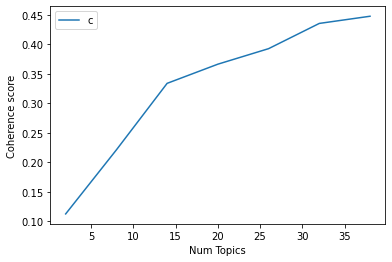

In [64]:
# Showing graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [65]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.1127
Num Topics = 8  has Coherence Value of 0.2213
Num Topics = 14  has Coherence Value of 0.3341
Num Topics = 20  has Coherence Value of 0.3666
Num Topics = 26  has Coherence Value of 0.3929
Num Topics = 32  has Coherence Value of 0.4357
Num Topics = 38  has Coherence Value of 0.4479


In [66]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.063*"nice" + 0.049*"girl" + 0.047*"miss" + 0.034*"stuff" + 0.033*"put" + '
  '0.032*"sit" + 0.032*"poor" + 0.031*"baby" + 0.023*"boy" + 0.021*"ready"'),
 (1,
  '0.132*"lol" + 0.060*"call" + 0.046*"phone" + 0.033*"send" + 0.031*"cry" + '
  '0.031*"break" + 0.026*"die" + 0.024*"haha" + 0.023*"twitt" + 0.021*"turn"'),
 (2,
  '0.121*"time" + 0.098*"week" + 0.072*"weekend" + 0.057*"long" + '
  '0.043*"awesome" + 0.025*"write" + 0.021*"hurt" + 0.021*"remember" + '
  '0.019*"back" + 0.019*"full"'),
 (3,
  '0.170*"feel" + 0.047*"sick" + 0.036*"bit" + 0.035*"hot" + 0.029*"weather" + '
  '0.024*"money" + 0.023*"drink" + 0.018*"cold" + 0.015*"bore" + 0.014*"eye"'),
 (4,
  '0.150*"today" + 0.074*"make" + 0.050*"school" + 0.030*"head" + 0.026*"hair" '
  '+ 0.020*"dinner" + 0.020*"anymore" + 0.015*"vote" + 0.014*"super" + '
  '0.014*"test"'),
 (5,
  '0.282*"work" + 0.071*"today" + 0.058*"leave" + 0.044*"lot" + 0.031*"forget" '
  '+ 0.026*"hour" + 0.025*"month" + 0.019*"totally" + 0.014*"ha

In [67]:
 
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()
  # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,15.0,0.0704,"bad, year, run, happen, car, back, stop, walk,...",i know i was listenin to bad habit earlier and...
1,1,0.0,0.0500,"nice, girl, miss, stuff, put, sit, poor, baby,...",Layin n bed with a headache ughhhh...waitin on...
2,2,9.0,0.0664,"home, back, find, finally, buy, stay, post, pl...",Funeral ceremony...gloomy friday...
3,3,10.0,0.0664,"watch, friend, show, movie, live, funny, excit...",wants to hang out with friends SOON!
4,4,15.0,0.0673,"bad, year, run, happen, car, back, stop, walk,...",We want to trade with someone who has Houston ...
5,5,1.0,0.0673,"lol, call, phone, send, cry, break, die, haha,...",Re-pinging why didnt you go to prom? BC my bf ...
6,6,14.0,0.0636,"tomorrow, tonight, start, rain, big, end, summ...","I should be sleep, but im not! thinking about ..."
7,7,13.0,0.0673,"quot, twitter, http, give, damn, problem, thou...",Hmmm. http://www.djhero.com/ is down
8,8,0.0,0.0500,"nice, girl, miss, stuff, put, sit, poor, baby,...",Charlene my love. I miss you
9,9,0.0,0.0500,"nice, girl, miss, stuff, put, sit, poor, baby,...",Im sorry at least its Friday?


In [68]:
# Grouping top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1213,"nice, girl, miss, stuff, put, sit, poor, baby,...",The wife gets stung by a bee and she has been ...
1,1.0,0.1542,"lol, call, phone, send, cry, break, die, haha,...",my computers broken and I broke my laptop so I...
2,2.0,0.1448,"time, week, weekend, long, awesome, write, hur...","Reinstalled Ubuntu on my laptop, this time usi..."
3,3.0,0.1615,"feel, sick, bit, hot, weather, money, drink, c...",stomach cramps; sat in bed with a hot water bo...
4,4.0,0.1319,"today, make, school, head, hair, dinner, anymo...","Lmao, when I was camping, the water in the sho..."


In [69]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,15.0,"bad, year, run, happen, car, back, stop, walk,...",6067.0,0.1517
1.0,0.0,"nice, girl, miss, stuff, put, sit, poor, baby,...",2495.0,0.0624
2.0,9.0,"home, back, find, finally, buy, stay, post, pl...",2115.0,0.0529
3.0,10.0,"watch, friend, show, movie, live, funny, excit...",2329.0,0.0582
4.0,15.0,"bad, year, run, happen, car, back, stop, walk,...",1791.0,0.0448
...,...,...,...,...
39995.0,0.0,"nice, girl, miss, stuff, put, sit, poor, baby,...",NaN,NaN
39996.0,8.0,"day, mom, mother, world, beautiful, enjoy, car...",NaN,NaN
39997.0,8.0,"day, mom, mother, world, beautiful, enjoy, car...",NaN,NaN
39998.0,14.0,"tomorrow, tonight, start, rain, big, end, summ...",NaN,NaN


## (2) (15 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [3]:

#importing modules
import os.path
import pandas as pd
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('/content/text_emotion.csv')

df.head()

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


In [5]:
def load_data(path,file_name):
    """
    Input  : path and file_name
    Purpose: loading text file
    Output : list of paragraphs/documents and
             title(initial 100 words considred as title of document)
    """
    documents_list = []
    titles=[]
    with open( os.path.join(path, file_name) ,"r") as fin:
        for line in fin.readlines():
            text = line.strip()
            documents_list.append(text)
    print("Total Number of Documents:",len(documents_list))
    titles.append( text[0:min(len(text),100)] )
    return documents_list,titles

In [11]:
def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts

In [25]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix
    dictionary,doc_term_matrix=prepare_corpus(texts)

In [20]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [21]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [22]:
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

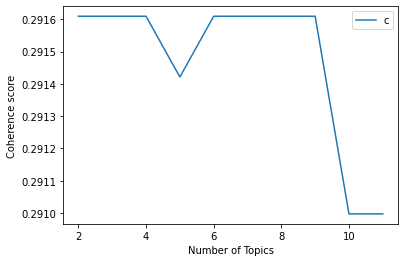

In [31]:
start,stop,step=2,12,1
plot_graph(texts,start,stop,step)

In [30]:
# LSA Model
import nltk
nltk.download('stopwords')
number_of_topics=7
words=10
document_list,titles=load_data("","/content/text_emotion.csv")
texts=preprocess_data(document_list)
model=create_gensim_lsa_model(texts,number_of_topics,words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Total Number of Documents: 40001
[(0, '0.411*"love" + 0.407*"worri" + 0.368*"happi" + 0.318*"neutral" + 0.263*"day" + 0.193*"sad" + 0.180*"go" + 0.144*"get" + 0.123*"good" + 0.120*"quot"'), (1, '-0.615*"worri" + 0.563*"love" + 0.375*"happi" + -0.274*"neutral" + 0.149*"day" + 0.135*"mother" + -0.096*"go" + -0.089*"sad" + -0.056*"work" + -0.056*"get"'), (2, '0.852*"neutral" + -0.495*"worri" + -0.096*"love" + -0.060*"sad" + 0.058*"http" + -0.053*"happi" + 0.047*"com" + -0.026*"day" + 0.023*"quot" + -0.022*"feel"'), (3, '0.647*"love" + -0.602*"happi" + -0.320*"sad" + -0.198*"day" + 0.176*"worri" + 0.105*"neutral" + -0.102*"mother" + -0.079*"work" + 0.072*"quot" + -0.059*"go"'), (4, '-0.862*"sad" + 0.357*"happi" + 0.239*"worri" + -0.140*"love" + -0.088*"miss" + 0.087*"neutral" + 0.077*"mother" + 0.071*"day" + -0.055*"quot" + -0.055*"fun"'), (5, '0.598*"quot" + -0.534*"day" + -0.299

## (3) (10 points) Compare the results generated by the two topic modeling algorithms, which one is better? You should explain the reasons in details.

In [ ]:
Coherence Score for LDA is 0.41722399661891724 and 
coherence score for LSA is 0.2916
LDA generates z matrices with all of the words in the data record as rows and all of the documents as columns.
 The LDA method assigns the word represented by the row and column to each value in the array, which is helpful for optimization.

 so,LDA is better than LSA




